# Implementation: Support Vector Machines

In [197]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
plt.rcParams["figure.figsize"] = (16,8)
# use seaborn plotting defaults
import seaborn as sns; sns.set()

## Support Vector Machines: Maximizing the *Margin*

Support vector machines offer one way to improve on this.
The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point.
Here is an example of how this might look:

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model.

In [198]:
from sklearn.svm import SVC 
model = SVC(kernel='linear', C=1E8)
model.fit(X, y)

SVC(C=100000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [199]:
def plot_svc_decision_function(model, ax=None, plot_support_vectors=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support_vectors:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

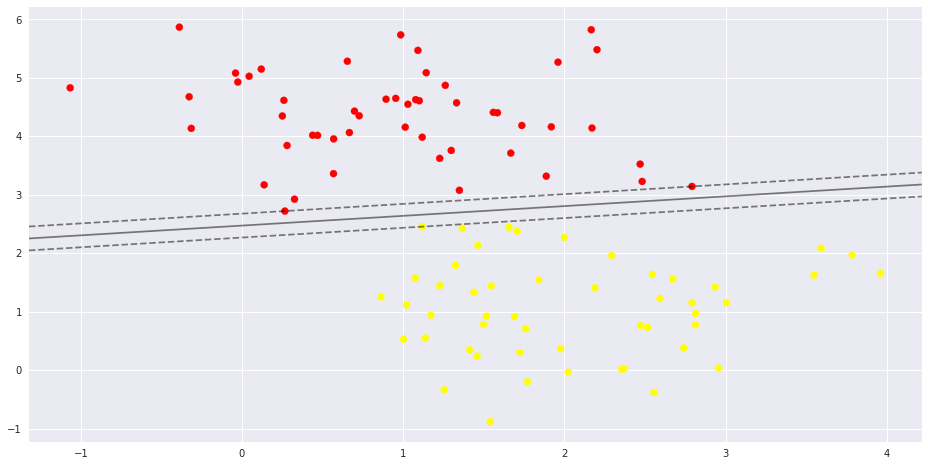

In [200]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

In [201]:
model.support_vectors_

array([[ 0.26604148,  2.71915015],
       [ 2.79207378,  3.14029479],
       [ 1.1167688 ,  2.45256061]])

A key to this classifier's success is that for the fit, __only the position of the support vectors matter__; any points further from the margin which are on the correct side do not modify the fit, these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.


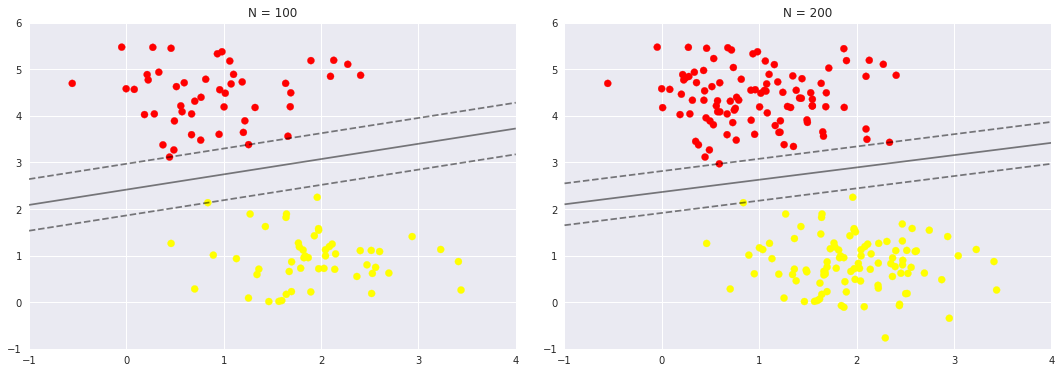

In [202]:
def plot_svm(N, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E8)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [100, 200]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

### Beyond linear boundaries: Kernel SVM

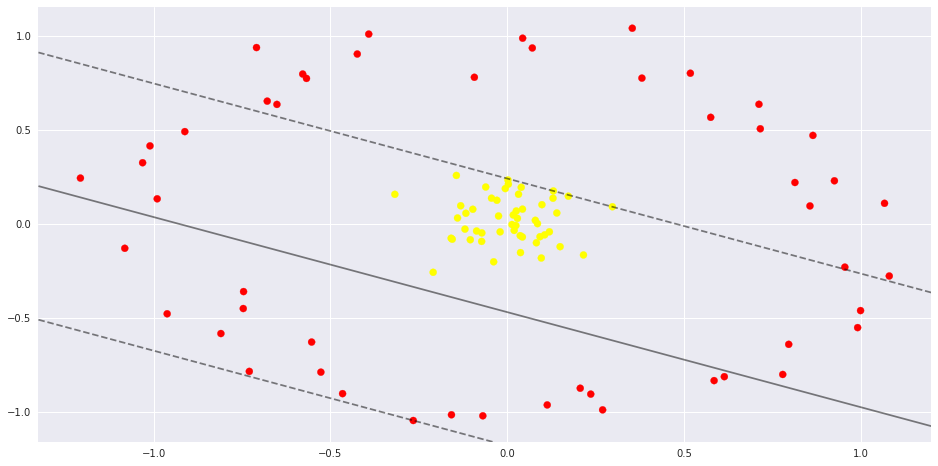

In [203]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

model = SVC(kernel='linear').fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model, plot_support_vectors=True);

It is clear that no linear discrimination will be able to separate this data.


- kernel

one simple projection we could use would be to compute a *radial basis function* centered on the middle clump:

In [204]:
kernel = np.exp(-(X ** 2).sum(1))

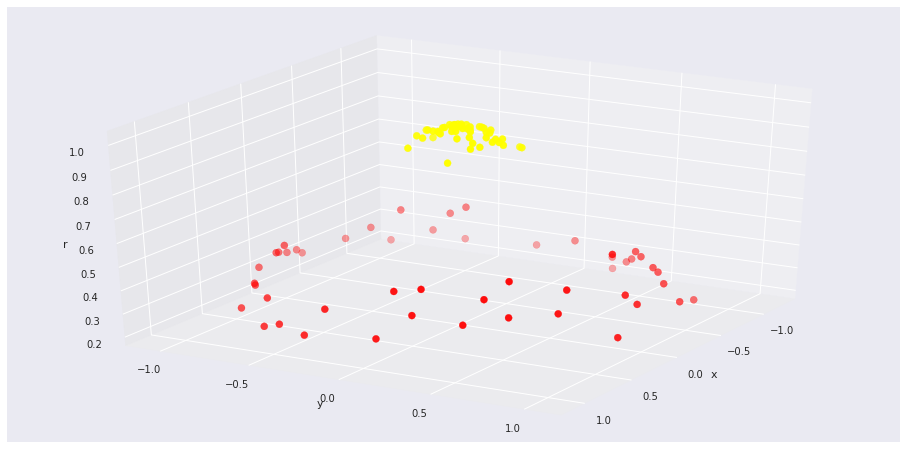

In [205]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], kernel, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')
    
    for tick in ax.w_xaxis.get_ticklines():
        tick.set_visible(False)
    for tick in ax.w_yaxis.get_ticklines():
        tick.set_visible(False)
    for tick in ax.w_zaxis.get_ticklines():
        tick.set_visible(False)

plot_3D()

In [206]:
clf = SVC(kernel='rbf', C=1E8)
clf.fit(X, y)

SVC(C=100000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

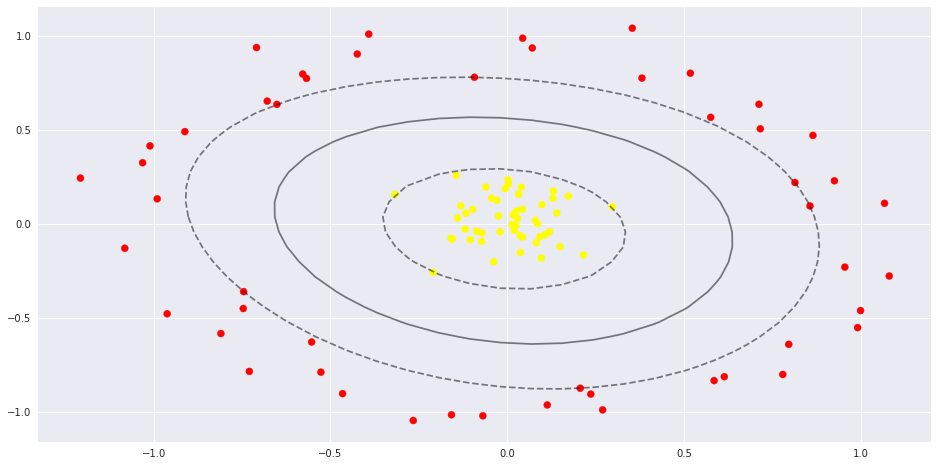

In [207]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

### Tuning the SVM: Softening Margins

The conclusion above thus far has centered around very clean datasets, in which __a perfect decision boundary exists__. But what if your data __has some amount of overlap__?

For example, what if we have data like this:

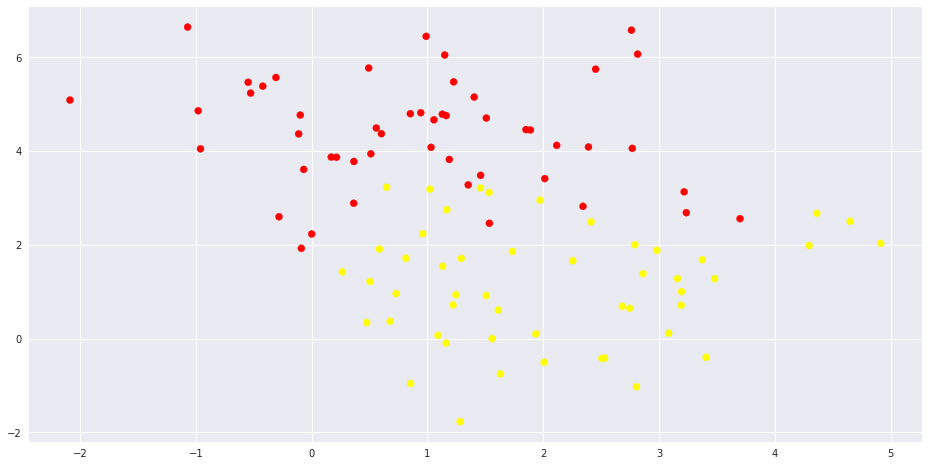

In [208]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

To handle this case, the SVM implementation has a bit of a fudge-factor which __"softens" the margin__: that is, it allows some of the points to creep into the margin if that allows a better fit.


__The hardness of the margin is controlled by a tuning parameter, most often known as C.__

For very large C, the margin is hard, and points cannot lie in it.

For smaller C, the margin is softer, and can grow to encompass some points.

> how a changing C parameter affects the final fit via the softening of the margin?

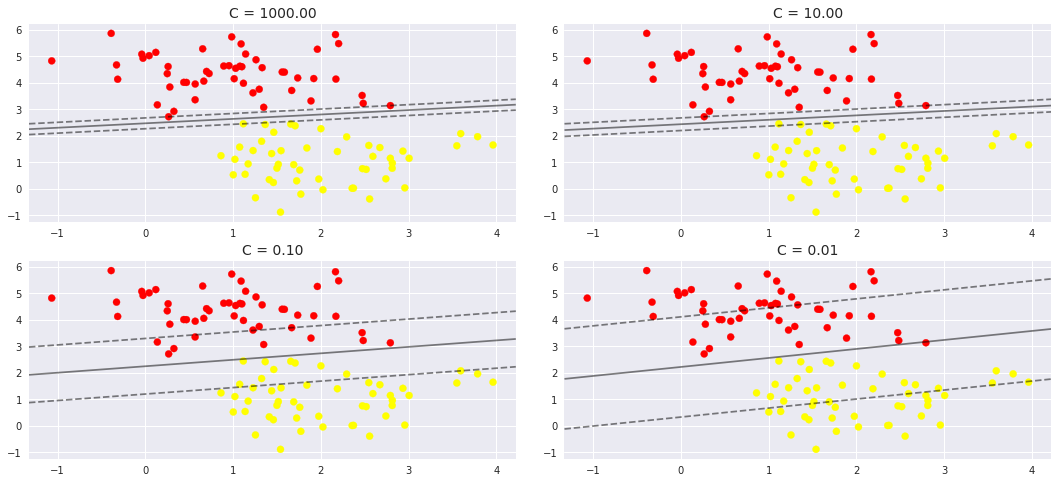

In [209]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(2,2)
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax.flat, [1000, 10.0, 0.1, 0.01]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.2f}'.format(C), size=14)

The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or a similar procedure 

## Example: Face Recognition


In [210]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
faces.target_names

/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/logger.py:77: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  logging.warning("[%s]: %s" % (self, msg))
 Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/memory.py", line 444, in _cached_call
    as functions are evaluated. The higher, the more verbose
  File "/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/memory.py", line 133, in _load_output
    if not os.path.isfile(filename):
  File "/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/numpy_pickle.py", line 459, in load
    if compress_method in _COMPRESSORS and compress_level == 0:
  File "/usr/lib/python3.5/pickle.py", line 1039, in load
    dispatch[key[0]](self)
KeyError: 120

/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1

/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr

/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr

/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr

/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr

/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr

/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr

/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr

/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr

/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr

/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr

/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr

/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr

/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr

/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr

/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr

/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr

/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr

/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr

/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr

/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr

/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr

/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:161: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.5/dist-packages/sklearn/datasets/lfw.py:170: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)


array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Junichiro Koizumi',
       'Tony Blair'],
      dtype='<U17')

In [211]:
faces.images.shape

(1348, 62, 47)

Let's plot a few of these faces to see what we're working with:

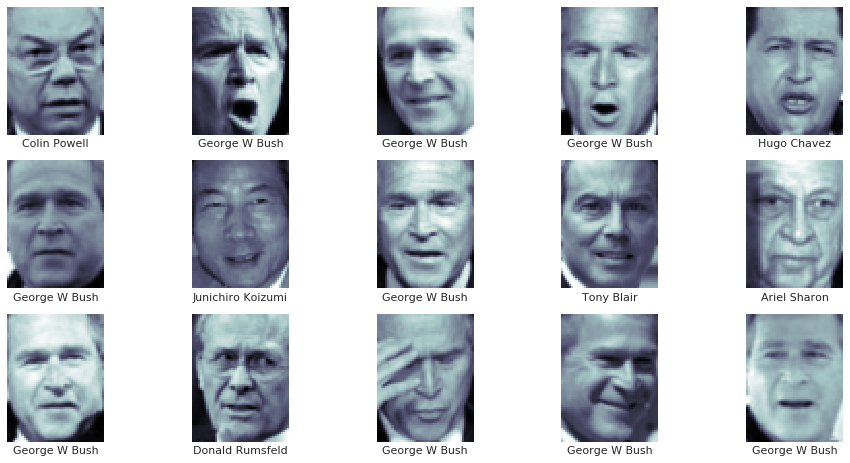

In [212]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap="bone")
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Each image contains [62×47] or nearly 3,000 pixels.


here:

__use a principal component analysis to extract 150 fundamental components to feed into our support vector machine classifier__

In [213]:
from sklearn.svm import SVC
from sklearn.decomposition import RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True, random_state=1)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [215]:
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=1)

Here we will adjust ``C`` (__which controls the margin hardness__) and ``gamma`` (__which controls the size of the radial basis function kernel__), and determine the best model:

In [217]:
from sklearn.grid_search import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

In [218]:
grid.score

<bound method BaseSearchCV.score of GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('randomizedpca', RandomizedPCA(copy=True, iterated_power=3, n_components=150, random_state=1,
       whiten=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'svc__gamma': [0.0001, 0.0005, 0.001, 0.005], 'svc__C': [1, 5, 10, 50]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)>

In [ ]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

In [ ]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

This helps us get a sense of which labels are likely to be confused by the estimator.

For a real-world facial recognition task, in which the photos do not come pre-cropped into nice grids, the only difference in the facial classification scheme is the feature selection: would need to use a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation.


For this kind of application, one good option is to make use of OpenCV, which, among other things, includes pre-trained implementations of some feature extraction tools for images in general and faces in particular.

## Support Vector Pros and Cons

- Pros 
    - Their dependence on relatively few support vectors indicates its compactness, and take up very little memory.
    - Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples.
    - Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

- Cons:
    - The results are strongly dependent on a suitable choice for the softening parameter C. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
    - The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (the ``probability`` parameter of ``SVC``), but this extra estimation is costly.
